In [69]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from coinmarketcap import Market
import csv, datetime
import sys
import os


%matplotlib inline

In [2]:
X = 5
initialize_date = "2016-01-01"
altfundx_currencies = ["LTC","BTC","ETH"]

In [55]:
historical_marketcap = pd.read_csv("data.csv").drop_duplicates(subset=['Symbol','Date'], keep='first')
historical_marketcap = historical_marketcap.loc[historical_marketcap['Is Mined'] == True]
x_historical_marketcap = historical_marketcap.groupby('Date', as_index=False).apply(lambda x: x.nlargest(X, 'Market Cap'))
ts_hist_cap = x_historical_marketcap.pivot(index='Date', columns='Symbol', values='Market Cap')
ts_hist_cap.index = pd.to_datetime(ts_hist_cap.index)
ts_hist_cap.sort_index(inplace=True)
ts_hist_cap = ts_hist_cap.loc[initialize_date:]
ts_hist_cap.dropna(axis=1, how='all', thresh=None, subset=None, inplace=True)
if "MIOTA" in ts_hist_cap.columns:
    ts_hist_cap.rename(index=str, columns={"MIOTA":"IOT"}, inplace=True)

ts_hist_cap.head()

Symbol,BCH,BTC,BTG,DASH,DOGE,EMC,ETC,ETH,LTC,XMR
Date,,,,,,,,,,
2016-01-03,NaN,6.487951e+09,NaN,19820453.0,15091783.0,NaN,NaN,72409494.0,153184845.0,NaN
2016-01-10,NaN,6.695068e+09,NaN,19254557.0,17805476.0,NaN,NaN,74621507.0,155022614.0,NaN
2016-01-17,NaN,5.810702e+09,NaN,24030404.0,15766176.0,NaN,NaN,94185825.0,135127839.0,NaN
2016-01-24,NaN,5.921312e+09,NaN,27784763.0,17812262.0,NaN,NaN,163842855.0,138289448.0,NaN
2016-01-31,NaN,5.747894e+09,NaN,25429609.0,25295002.0,NaN,NaN,189559249.0,137354970.0,NaN


In [6]:
mined_currencies = list(ts_hist_cap.columns)
print(mined_currencies)
#altfundx_currencies = mined_currencies
ts_hist_cap = ts_hist_cap[altfundx_currencies]
ts_hist_cap.head()

['LTC', 'BTC', 'ETH']


Symbol,LTC,BTC,ETH
Date,,,
2016-01-03,153184845.0,6.487951e+09,72409494.0
2016-01-10,155022614.0,6.695068e+09,74621507.0
2016-01-17,135127839.0,5.810702e+09,94185825.0
2016-01-24,138289448.0,5.921312e+09,163842855.0
2016-01-31,137354970.0,5.747894e+09,189559249.0


In [53]:
quandl.ApiConfig.api_key = '-GNvgv_nqBHeqiyEQjyj'
symbol_usd_pairs = {x:None for x in altfundx_currencies}

for symbol in altfundx_currencies:
    bnc_symbol_1 = "MWA_{}_USD".format(symbol)
    bnc_symbol_2 = "MWA_{}_BTC_USD".format(symbol)
    bnc_symbol_3 = "MWA_{}_ETH_USD".format(symbol)
    all_bnc = [
        bnc_symbol_1,
        bnc_symbol_2,
        bnc_symbol_3
    ]
    for bnc_symbol in all_bnc:
        try:
            data = quandl.get("BNC2/"+bnc_symbol)
            break
        except:
            bnc_symbol = None
    if bnc_symbol:
        print("For Currency {} - BNC symbol is {}".format(symbol, bnc_symbol))
    else:
        print("For Currency {} - No BNC symbol".format(symbol))
    symbol_usd_pairs[symbol] = bnc_symbol

print(symbol_usd_pairs)

For Currency LTC - BNC symbol is MWA_LTC_USD
For Currency BTC - BNC symbol is MWA_BTC_USD
For Currency ETH - BNC symbol is MWA_ETH_USD
{'BTC': 'MWA_BTC_USD', 'LTC': 'MWA_LTC_USD', 'ETH': 'MWA_ETH_USD'}


In [8]:
ts_hist_cap.index.min()

Timestamp('2016-01-03 00:00:00')

In [56]:
hist_pricing = {x:None for x in altfundx_currencies}
for altfundx_instrument in symbol_usd_pairs:
    df0 = quandl.get("BNC2/"+symbol_usd_pairs[altfundx_instrument], start_date=ts_hist_cap.index.min())
    df = pd.DataFrame(df0, columns=["VWAP"])
    #print(altfundx_instrument)
    #print(df.head())
    df.columns = ["PRICE"]
    df.index.rename("DATETIME", inplace=True)
    hist_pricing[altfundx_instrument] = df

In [10]:

ts_hist_cap_pct = ts_hist_cap.div(ts_hist_cap.sum(1),0)
ts_hist_cap_pct.head()

Symbol,LTC,BTC,ETH
Date,,,
2016-01-03,0.022817,0.966397,0.010786
2016-01-10,0.022387,0.966837,0.010776
2016-01-17,0.022372,0.962034,0.015594
2016-01-24,0.022221,0.951453,0.026327
2016-01-31,0.022611,0.946185,0.031204


In [11]:
from functools import reduce

values_dict = {x:None for x in ts_hist_cap_pct.columns}
values_list = []

for asset in ts_hist_cap_pct.columns:
    #asset = "BTC"
    weight_price_df = ts_hist_cap_pct[[asset]].merge(hist_pricing[asset], right_index=True, left_index=True, how="outer").fillna(method='ffill')
    value_df0 = (weight_price_df[asset] * weight_price_df["PRICE"])
    value_df = pd.DataFrame(value_df0, columns=[asset])
    value_df.columns = [asset]
    value_df.index.rename("Date", inplace=True)
    #print(value_df.head())
    values_list.append(value_df)

index_values = reduce(lambda df1, df2: df1.merge(df2, "outer", right_index=True, left_index=True), values_list)
index_values.head()

,LTC,BTC,ETH
Date,,,
2016-01-03,0.079036,415.841449,0.011257
2016-01-04,0.079247,417.815412,0.010235
2016-01-05,0.079090,419.339742,0.009959
2016-01-06,0.078712,417.132328,0.010245
2016-01-07,0.081003,435.797228,0.010312


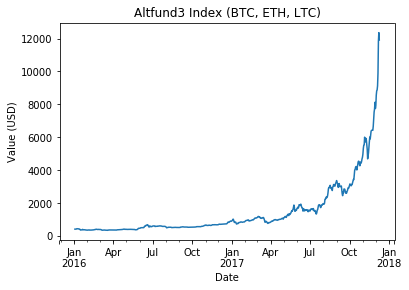

In [12]:
index_values.sum(axis=1).plot()
plt.ylabel('Value (USD)')
plt.title('AltfundX '+str(altfundx_currencies))
plt.savefig('AltfundX.png')
plt.show()

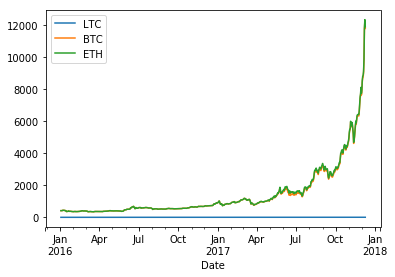

In [13]:
#plt.stackplot(index_values.index,*[ts for col, ts in index_values.iteritems()])
#plt.show()
index_values.plot(stacked=True)

In [14]:
current_marketcap = pd.read_csv("coinmarketcap_ticker_data_dump.csv")
current_marketcap.head()

,ID,NAME,SYMBOL,RANK,PRICE_USD,PRICE_BTC,24H_VOLUMNE_USD,MARKET_CAP_USD,AVAILABLE SUPPLY,TOTAL_SUPPLY,MAX_SUPPLY,%1HR,%24HR,%7D,LAST UPDATED,TIMESTAMP
0,bitcoin,Bitcoin,BTC,1,11153.700000,1.000000,5.231050e+09,1.864429e+11,1.671579e+07,1.671579e+07,2.100000e+07,0.17,1.91,27.38,1512253450,2017-12-02 22:26:08.632507
1,ethereum,Ethereum,ETH,2,465.142000,0.042249,9.777450e+08,4.469790e+10,9.609518e+07,9.609518e+07,NaN,-0.00,-0.54,-0.40,1512253455,2017-12-02 22:26:08.632569
2,bitcoin-cash,Bitcoin Cash,BCH,3,1451.000000,0.131796,5.887420e+08,2.442655e+10,1.683429e+07,1.683429e+07,2.100000e+07,-0.36,-0.71,-8.87,1512253473,2017-12-02 22:26:08.632592
3,ripple,Ripple,XRP,4,0.255639,0.000023,1.250330e+08,9.873512e+09,3.862287e+10,9.999317e+10,1.000000e+11,0.11,-0.52,1.32,1512253441,2017-12-02 22:26:08.632611
4,dash,Dash,DASH,5,773.350000,0.070244,1.899600e+08,5.973510e+09,7.724200e+06,7.724200e+06,1.890000e+07,-0.15,-3.17,21.42,1512253442,2017-12-02 22:26:08.632625


In [26]:
def coinmarketcap_tickerdump():
    savedir = os.getcwd()

    assert os.path.exists(savedir), "I did not find the file at, "+str(savedir)

    coinmarketcap = Market()
    coinmarket_ticker_data = coinmarketcap.ticker(convert = 'USD')

    with open(os.path.join(savedir, 'coinmarketcap_tickerdump.csv'),'w', newline = '') as myfile:
        wr = csv.writer(myfile) #, quoting=csv.QUOTE_ALL)
        wr.writerow([' ID ', 'NAME', 'SYMBOL', 'RANK', 'PRICE_USD', 'PRICE_BTC', '24H_VOLUMNE_USD', 'MARKET_CAP_USD', 'AVAILABLE SUPPLY',
                     'TOTAL_SUPPLY', 'MAX_SUPPLY', '%1HR', '%24HR', '%7D', "LAST UPDATED", "TIMESTAMP"])
        for i in range(len(coinmarket_ticker_data)):
            wr.writerow(
                [coinmarket_ticker_data[i]['id'],
                coinmarket_ticker_data[i]['name'],
                coinmarket_ticker_data[i]['symbol'],
                coinmarket_ticker_data[i]['rank'],
                coinmarket_ticker_data[i]['price_usd'],
                coinmarket_ticker_data[i]['price_btc'],
                coinmarket_ticker_data[i]['24h_volume_usd'],
                coinmarket_ticker_data[i]['market_cap_usd'],
                coinmarket_ticker_data[i]['available_supply'],
                coinmarket_ticker_data[i]['total_supply'],
                coinmarket_ticker_data[i]['max_supply'],
                coinmarket_ticker_data[i]['percent_change_1h'],
                coinmarket_ticker_data[i]['percent_change_24h'],
                coinmarket_ticker_data[i]['percent_change_7d'],
                coinmarket_ticker_data[i]['last_updated'],
                datetime.datetime.now()]
            )

In [27]:
def get_current_pricing(file_name="coinmarketcap_tickerdump.csv"):
    try:
        current_marketcap = pd.read_csv(file_name)
    except:
        coinmarketcap_tickerdump()
        current_marketcap = pd.read_csv('coinmarketcap_tickerdump.csv')
        
    return(current_marketcap)

In [65]:
def current_holdings_value(current_holdings={}, base_currency="USD",current_pricing=None):
    current_pricing = get_current_pricing(current_pricing)
    
    holdings_value = 0
    for currency in current_holdings:
        conversion_factor = float(current_pricing[current_pricing["SYMBOL"]==currency]["PRICE_USD"]) if currency != base_currency else 1
        #print(conversion_factor)
        
        holdings_value += current_holdings[currency] * conversion_factor
    return(holdings_value)
    # What is the current value of the portfolio in terms of the base currency

In [48]:
def calculate_altfundx_allocation(currencies=altfundx_currencies, aum_usd=1000, current_marketcap=None):
    
    current_marketcap = get_current_pricing(current_marketcap)
    
    altfundX = current_marketcap.loc[current_marketcap['SYMBOL'].isin(currencies)].nlargest(X,'MARKET_CAP_USD')
    #altfundX = current_marketcap.nlargest(X,'MARKET_CAP_USD')
    altfundX['allocation_percent'] = altfundX[['MARKET_CAP_USD']]/altfundX[['MARKET_CAP_USD']].sum()
    altfundX['allocation_rounded_percent'] = (round(altfundX['allocation_percent']*100,2)*(100/round(altfundX['allocation_percent']*100,2).sum()))
    altfundX['rounded_price_usd'] = round(altfundX['PRICE_USD'],2)
    aum_usd = 1000
    #allocation_column_name = 'coins_per_'+str(aum_usd)+'_usd'
    altfundX['optimal_holdings'] = (aum_usd * altfundX['allocation_percent'])/altfundX['PRICE_USD']
    return(altfundX[['SYMBOL','allocation_rounded_percent','rounded_price_usd','optimal_holdings']])

In [74]:
current_holdings = {"USD":1430.36, "BTC":0.04185700, "ETH":0.24091210, "LTC":0.13581700}
holdings_value = current_holdings_value(current_holdings=current_holdings, base_currency="USD",current_pricing=None)
print("portfolio value: ",holdings_value," USD")
altfundX = calculate_altfundx_allocation(currencies=altfundx_currencies, aum_usd=holdings_value*.95, current_marketcap="coinmarketcap_tickerdump.csv")
print(altfundX)

portfolio value:  2426.6319141327  USD
  SYMBOL  allocation_rounded_percent  rounded_price_usd  optimal_holdings
0    BTC                   79.172083           18845.40          0.042014
1    ETH                   16.738326             692.16          0.241813
4    LTC                    4.089591             299.75          0.136325


In [75]:
holdings_value*.95

2305.3003184260647

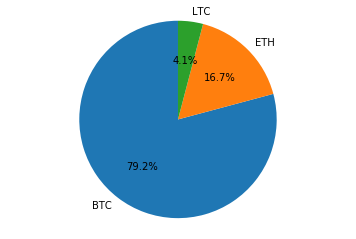

In [76]:
def plot_allocation(allocation=altfundX):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = allocation['SYMBOL']
    sizes = allocation['allocation_rounded_percent']
    #explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
plot_allocation()

In [77]:
optimal_holdings = dict(zip(altfundX.SYMBOL, altfundX.optimal_holdings))
# need to get this to include the intersection of the current_holdings & optimal_holdings sets
holdings_diff = {x: (optimal_holdings[x] if x in optimal_holdings else 0) - (current_holdings[x] if x in current_holdings else 0) for x in list(set(list(optimal_holdings.keys())+list(current_holdings.keys())))}
print("current: ",current_holdings)
print("optimal: ",optimal_holdings)
print("diffs: ",holdings_diff)

current:  {'BTC': 0.041857, 'LTC': 0.135817, 'ETH': 0.2409121, 'USD': 1430.36}
optimal:  {'BTC': 0.042013656031393815, 'LTC': 0.13632536416945615, 'ETH': 0.24181284743423911}
diffs:  {'BTC': 0.00015665603139381618, 'LTC': 0.0005083641694561547, 'ETH': 0.0009007474342391242, 'USD': -1430.36}


In [ ]:
# orders_to_make
# 

In [59]:
import gdax

In [61]:
public_client = gdax.PublicClient()
markets = public_client.get_products()

In [62]:
markets

[{'base_currency': 'LTC',
  'base_max_size': '1000000',
  'base_min_size': '0.01',
  'display_name': 'LTC/EUR',
  'id': 'LTC-EUR',
  'margin_enabled': False,
  'quote_currency': 'EUR',
  'quote_increment': '0.01',
  'status': 'online',
  'status_message': None},
 {'base_currency': 'LTC',
  'base_max_size': '1000000',
  'base_min_size': '0.01',
  'display_name': 'LTC/USD',
  'id': 'LTC-USD',
  'margin_enabled': False,
  'quote_currency': 'USD',
  'quote_increment': '0.01',
  'status': 'online',
  'status_message': None},
 {'base_currency': 'LTC',
  'base_max_size': '1000000',
  'base_min_size': '0.01',
  'display_name': 'LTC/BTC',
  'id': 'LTC-BTC',
  'margin_enabled': False,
  'quote_currency': 'BTC',
  'quote_increment': '0.00001',
  'status': 'online',
  'status_message': None},
 {'base_currency': 'ETH',
  'base_max_size': '5000',
  'base_min_size': '0.001',
  'display_name': 'ETH/EUR',
  'id': 'ETH-EUR',
  'margin_enabled': False,
  'quote_currency': 'EUR',
  'quote_increment': '0.0

In [ ]:
# given all the diffs
# make all possible markets for the currencies
# go through each market and create the trades that would solve the diffs
# for markets that don't actually exist, find the markets that do actually exist to create that artificial market and make the necessary markets among those
# 


# given all of the markets available for the currencies
# given all the diffs that need to happen...
# Can we assume BTC basis for everything? Don't need to.
# For every diff:
    # if the diff is positive, we are therefore buying
        # find all markets with base currency of that diff
        # find all markets with quote_currency where we have negative diff
        # for every market isolated:
            # create an order that would be at most the amount we need to buy/sell of the underlying currencies
            # 